# Using a Neural Networkt recognize execution patterns using hardware performance counters

Load libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.utils import to_categorical
import seaborn as sns
dataset = pd.read_csv('patterns.csv',sep=';')
dataset_NAS = pd.read_csv('NAS-clean.csv',sep=';')

Using TensorFlow backend.
/home/ssleder/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ssleder/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ssleder/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ssleder/.local/lib/python3.6/site-packages/tensorflow/py

Shuffle data, necessary to mix the rows in the dataset in order to have training and testing data with all the cases.
If the data is not shuffled, the cur for the test7train pair will be done at exacty the x-th position in the dataset.

In [2]:
from sklearn.utils import shuffle
dataset = shuffle(dataset)
print('first:', dataset['label'].unique())
print('other:', dataset_NAS['label'].unique())

first: ['Test' '2PStencil' '2D4PStencil' 'Reduction' 'Triad' 'Add' 'Rows'
 'Stride64' 'Scatter' 'Stride4' 'Stride16' 'Stride2' 'Gather' 'Scale'
 'Copy']
other: ['Add_BT' 'Triad_BT' 'Triad_Red_rhorr' 'Triad_similar_qAp'
 'Triad_multi_z_alpha_p' 'Triad_pr_beta_p' 'Triad_norm_temps'
 'Scale_normztox' 'Triad_similar_l2norm' 'Triad_ssor_triad']


In [3]:
sorted(dataset['size vector'].unique())

[1000,
 2000,
 3000,
 4000,
 5000,
 6000,
 7000,
 8000,
 9000,
 10000,
 20000,
 30000,
 40000,
 50000,
 60000,
 70000,
 80000,
 90000,
 100000,
 200000,
 300000,
 400000,
 500000,
 600000,
 700000,
 800000,
 900000,
 1000000,
 2000000,
 3000000,
 5000000,
 7000000,
 9000000,
 20000000,
 40000000,
 60000000,
 80000000,
 100000000,
 120000000,
 140000000,
 160000000,
 180000000,
 200000000]

Creating the dataset which will be used in the training step.
Two sizes are removed in order to test if unseen data can be used to identify the patterns.

Generate the dataset with the two sizes to predict

In [4]:
print(dataset.columns)

Index(['id', 'size vector', 'comp opt', 'label', 'threads', 'PAPI_L1_DCM',
       'PAPI_L3_TCM', 'PAPI_TOT_INS', 'PAPI_REF_CYC', 'PAPI_L2_LDM',
       'PAPI_SR_INS', 'PAPI_BR_UCN', 'PAPI_BR_CN', 'PAPI_BR_TKN',
       'PAPI_BR_MSP', 'PAPI_FP_OPS', 'PAPI_L1_LDM', 'PAPI_L1_STM',
       'PAPI_SP_OPS', 'PAPI_LD_INS', 'PAPI_L2_STM', 'PAPI_TLB_DM',
       'PAPI_L2_DCH', 'affinity'],
      dtype='object')


Remove extra columns and hardware performance counters discarded with PCA

In [5]:
def erase_from_dataset(dataset_in):
    del dataset_in['id']
    del dataset_in['size vector']
    del dataset_in['comp opt']
    del dataset_in['threads']
    del dataset_in['affinity']
    dataset_in = dataset_in.reset_index(drop=True)
    dataset_in.info()
    
erase_from_dataset(dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548000 entries, 0 to 1547999
Data columns (total 19 columns):
label           1548000 non-null object
PAPI_L1_DCM     1548000 non-null int64
PAPI_L3_TCM     1548000 non-null int64
PAPI_TOT_INS    1548000 non-null int64
PAPI_REF_CYC    1548000 non-null int64
PAPI_L2_LDM     1548000 non-null int64
PAPI_SR_INS     1548000 non-null int64
PAPI_BR_UCN     1548000 non-null int64
PAPI_BR_CN      1548000 non-null int64
PAPI_BR_TKN     1548000 non-null int64
PAPI_BR_MSP     1548000 non-null int64
PAPI_FP_OPS     1548000 non-null int64
PAPI_L1_LDM     1548000 non-null int64
PAPI_L1_STM     1548000 non-null int64
PAPI_SP_OPS     1548000 non-null int64
PAPI_LD_INS     1548000 non-null int64
PAPI_L2_STM     1548000 non-null int64
PAPI_TLB_DM     1548000 non-null int64
PAPI_L2_DCH     1548000 non-null int64
dtypes: int64(18), object(1)
memory usage: 224.4+ MB


In [6]:
def erase_from_dataset_NAS(dataset_in):
    del dataset_in['id']
    del dataset_in['size vector']
    del dataset_in['comp opt']
    del dataset_in['threads']
    del dataset_in['affinity']
    dataset_in = dataset_in.reset_index(drop=True)
    dataset_in.info()
    
erase_from_dataset_NAS(dataset_NAS)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153240 entries, 0 to 153239
Data columns (total 19 columns):
label           153240 non-null object
PAPI_L1_DCM     153240 non-null int64
PAPI_L3_TCM     153240 non-null int64
PAPI_TOT_INS    153240 non-null int64
PAPI_REF_CYC    153240 non-null int64
PAPI_L2_LDM     153240 non-null int64
PAPI_SR_INS     153240 non-null int64
PAPI_BR_UCN     153240 non-null int64
PAPI_BR_CN      153240 non-null int64
PAPI_BR_TKN     153240 non-null int64
PAPI_BR_MSP     153240 non-null int64
PAPI_FP_OPS     153240 non-null int64
PAPI_L1_LDM     153240 non-null int64
PAPI_L1_STM     153240 non-null int64
PAPI_SP_OPS     153240 non-null int64
PAPI_LD_INS     153240 non-null int64
PAPI_L2_STM     153240 non-null int64
PAPI_TLB_DM     153240 non-null int64
PAPI_L2_DCH     153240 non-null int64
dtypes: int64(18), object(1)
memory usage: 22.2+ MB


In [7]:
dataset.columns

Index(['label', 'PAPI_L1_DCM', 'PAPI_L3_TCM', 'PAPI_TOT_INS', 'PAPI_REF_CYC',
       'PAPI_L2_LDM', 'PAPI_SR_INS', 'PAPI_BR_UCN', 'PAPI_BR_CN',
       'PAPI_BR_TKN', 'PAPI_BR_MSP', 'PAPI_FP_OPS', 'PAPI_L1_LDM',
       'PAPI_L1_STM', 'PAPI_SP_OPS', 'PAPI_LD_INS', 'PAPI_L2_STM',
       'PAPI_TLB_DM', 'PAPI_L2_DCH'],
      dtype='object')

In [8]:
dataset_NAS.columns

Index(['label', 'PAPI_L1_DCM', 'PAPI_L3_TCM', 'PAPI_TOT_INS', 'PAPI_REF_CYC',
       'PAPI_L2_LDM', 'PAPI_SR_INS', 'PAPI_BR_UCN', 'PAPI_BR_CN',
       'PAPI_BR_TKN', 'PAPI_BR_MSP', 'PAPI_FP_OPS', 'PAPI_L1_LDM',
       'PAPI_L1_STM', 'PAPI_SP_OPS', 'PAPI_LD_INS', 'PAPI_L2_STM',
       'PAPI_TLB_DM', 'PAPI_L2_DCH'],
      dtype='object')

In [9]:
dataset_NAS.columns.difference(dataset.columns)

Index([], dtype='object')

Divide dataset hardware performance counters and labels

In [10]:
X = dataset.iloc[:,1:19].values
y = dataset.iloc[:,0].values

Normalize data

In [11]:
from sklearn.preprocessing import Normalizer
scaler_x = Normalizer()
scaler_x.fit(X)
X_scaled =  scaler_x.transform(X)

Encode labels in numeric categories

In [12]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
y1 = encoder.fit_transform(y)
Y = pd.get_dummies(y1).values

In [13]:
from keras.constraints import Constraint
from keras import backend as K

class ClipWeights(Constraint):
    def __init__(self, low, high):
        self.low = low
        self.high = high
        
    def __call__(self, weight):
        return K.clip(weight, self.low, self.high)
    

Load keras NN libraries and create empty NN

In [14]:
#Defining the model 
from keras.models import Sequential
from keras.layers import Dense, Dropout, GaussianNoise
from keras.optimizers import Adam

model = Sequential()

Add input layer for the 18 hardware counters
Add one hidden layer
And one output layer
Then compile the model

In [15]:
#model.add(GaussianNoise(0.0001, input_shape=(18,)))
model.add(Dense(18, activation='selu', input_shape=(18,), kernel_constraint=ClipWeights(-10.0,10.0)))
model.add(Dropout(0.1))
model.add(Dense(16, activation='selu', kernel_constraint=ClipWeights(-10.0,10.0)))
model.add(Dropout(0.1))
model.add(Dense(15, activation='softmax', kernel_constraint=ClipWeights(-10.0,10.0)))

model.compile(Adam(lr=0.001), 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 18)                342       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                304       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                255       
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________


Execute the neural network

In [16]:
history = model.fit(X_scaled,Y,batch_size=100,epochs=24,shuffle=True,validation_split=0.20)


Train on 1238400 samples, validate on 309600 samples
Epoch 1/24
1238400/1238400 [==============================] - 30s 24us/step - loss: 0.7832 - accuracy: 0.7601 - val_loss: 0.3102 - val_accuracy: 0.9260
Epoch 2/24
1238400/1238400 [==============================] - 29s 24us/step - loss: 0.3348 - accuracy: 0.9006 - val_loss: 0.2402 - val_accuracy: 0.9264
Epoch 3/24
1238400/1238400 [==============================] - 28s 23us/step - loss: 0.2803 - accuracy: 0.9167 - val_loss: 0.2116 - val_accuracy: 0.9500
Epoch 4/24
1238400/1238400 [==============================] - 41s 33us/step - loss: 0.2544 - accuracy: 0.9243 - val_loss: 0.1780 - val_accuracy: 0.9531
Epoch 5/24
1238400/1238400 [==============================] - 30s 24us/step - loss: 0.2375 - accuracy: 0.9294 - val_loss: 0.1950 - val_accuracy: 0.9408
Epoch 6/24
1238400/1238400 [==============================] - 28s 23us/step - loss: 0.2259 - accuracy: 0.9320 - val_loss: 0.1676 - val_accuracy: 0.9574
Epoch 7/24
1238400/1238400 [======

See the evolution of the model

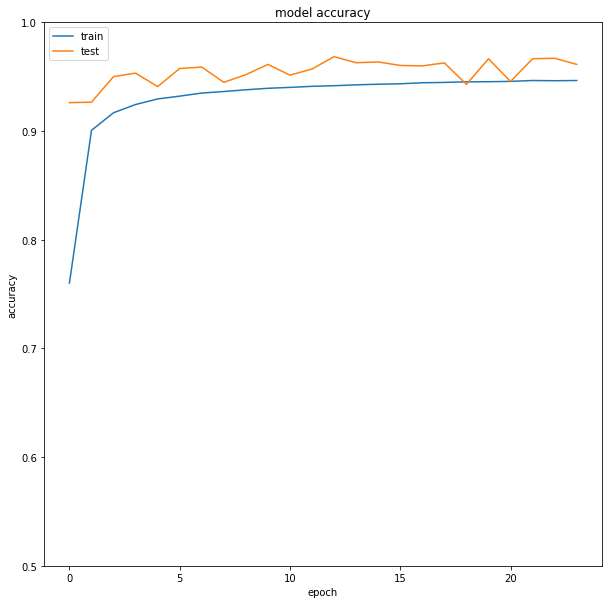

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
plt.ylim(0.5,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

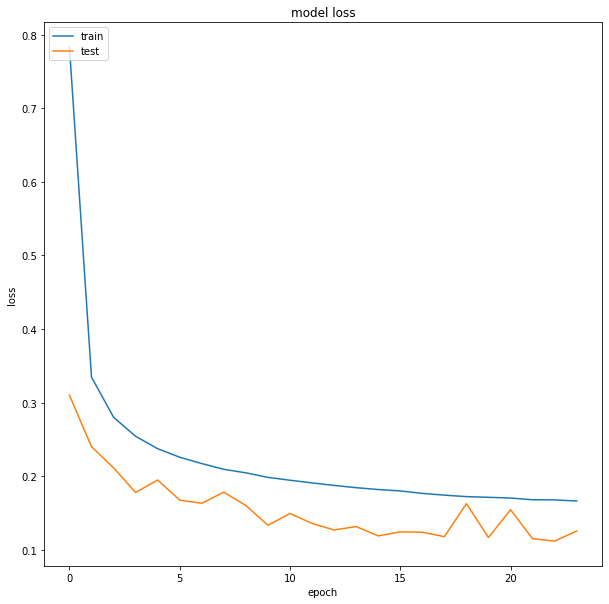

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
n = model.layers[0].get_weights()
sig = []

for i, (w, b) in enumerate(zip(n[0], n[1])):
    print('Node #{} weights:'.format(i))
    print('\tmin: {0:7.3f} at: {1:3}\n\tavg: {2:7.3f}\n\tmax: {3:7.3f} at: {4:3}'.format(np.amin(w), \
        np.argmin(w), np.average(w), np.amax(w), np.argmax(w)))
    print('Node #{0} bias: {1:7.3f}\n'.format(i, b))
    sig.append(np.argmin(w))
    sig.append(np.argmax(w))
    
print('Most common column for weight extrema:')
col = dataset.columns[1:19]
uniq, cnts = np.unique(sig, return_counts=True)
print(uniq)
for (u, c) in zip(uniq, cnts):
    print('\tCol: {0:13s} Freq:{1:2d}'.format(col[u], c))
    
m_freq = np.argmax(cnts)
print('Most Freq. Col: {0:13s} Freq{1:2d}'.format(col[m_freq], cnts[m_freq]))

Node #0 weights:
	min:  -9.944 at:   8
	avg:   0.499
	max:   9.999 at:   9
Node #0 bias:  -0.080

Node #1 weights:
	min:  -5.631 at:   8
	avg:  -0.144
	max:   3.024 at:  16
Node #1 bias:   0.070

Node #2 weights:
	min:  -0.114 at:   1
	avg:  -0.011
	max:   0.091 at:   0
Node #2 bias:   0.198

Node #3 weights:
	min:  -0.224 at:   8
	avg:   0.031
	max:   0.226 at:  11
Node #3 bias:  -0.068

Node #4 weights:
	min:  -8.512 at:   5
	avg:   0.609
	max:   9.998 at:   3
Node #4 bias:  -0.082

Node #5 weights:
	min:  -3.918 at:   1
	avg:  -0.266
	max:   3.634 at:  13
Node #5 bias:  -0.116

Node #6 weights:
	min:  -9.997 at:  16
	avg:   0.519
	max:   9.990 at:   7
Node #6 bias:   0.002

Node #7 weights:
	min:  -0.641 at:  11
	avg:  -0.036
	max:   0.129 at:   9
Node #7 bias:  -0.099

Node #8 weights:
	min:  -0.310 at:  10
	avg:   0.029
	max:   0.929 at:  11
Node #8 bias:   0.225

Node #9 weights:
	min:  -9.994 at:  13
	avg:   0.477
	max:   9.989 at:   7
Node #9 bias:   0.124

Node #10 weights:
	m

In [20]:
dataset_pred = dataset_NAS

Divide dataset hardware performance counters and labels

In [21]:
X_pred = dataset_pred.iloc[:,1:21].values
y_pred = dataset_pred.iloc[:,0].values

Normalize the data

In [22]:
X_pred_scaled = scaler_x.fit_transform(X_pred)

Use the network to predict the labels and transform the output to the pattern's labels

In [23]:
predictions = model.predict_classes(X_pred_scaled)
prediction_ = np.argmax(to_categorical(predictions), axis = 1)
prediction_ = encoder.inverse_transform(prediction_)

Classify the results in 'NAS pattern' predicted as: 'pattern (from patterns.csv)'

In [24]:
predicted_as={}
for i, j in zip(prediction_ , y_pred):
    pattern_as = str(j + " -- predicted as: " + i)
    if pattern_as not in predicted_as:
        predicted_as[pattern_as] = 0
    predicted_as[pattern_as] = predicted_as[pattern_as] + 1

Store and show results

In [25]:
with open('NAS-cleaned.txt', 'a+') as out:
    for i in sorted(predicted_as):
        print ( i , " --> ", predicted_as[i] )
        out.write(str(i) +  " --> " + str(predicted_as[i]) + "\n")
    out.write("--------------------------------------------------------------------------\n")

Add_BT -- predicted as: Add  -->  4745
Add_BT -- predicted as: Triad  -->  79
Scale_normztox -- predicted as: Scale  -->  1824
Triad_BT -- predicted as: Test  -->  24
Triad_Red_rhorr -- predicted as: Reduction  -->  1820
Triad_Red_rhorr -- predicted as: Test  -->  4
Triad_multi_z_alpha_p -- predicted as: 2D4PStencil  -->  45600
Triad_norm_temps -- predicted as: Reduction  -->  1822
Triad_norm_temps -- predicted as: Test  -->  2
Triad_pr_beta_p -- predicted as: Triad  -->  45600
Triad_similar_l2norm -- predicted as: Test  -->  96
Triad_similar_qAp -- predicted as: Reduction  -->  45600
Triad_ssor_triad -- predicted as: Triad  -->  6024


Number of row with each pattern

In [26]:
df = pd.DataFrame(dataset_NAS, columns= ['label'])
df.pivot_table(index=['label'], aggfunc='size')

label
Add_BT                    4824
Scale_normztox            1824
Triad_BT                    24
Triad_Red_rhorr           1824
Triad_multi_z_alpha_p    45600
Triad_norm_temps          1824
Triad_pr_beta_p          45600
Triad_similar_l2norm        96
Triad_similar_qAp        45600
Triad_ssor_triad          6024
dtype: int64

In [27]:
#%%javascript
#Jupyter.notebook.session.delete();